## Search by QSVT (Amplitude Amplification)

> Please read [A Grand Unification of Quantum Algorithms](https://arxiv.org/abs/2105.02859) and watch [Isaac Chuang - Grand unification of quantum algorithms](https://www.youtube.com/watch?v=GFRojXdrVXI&t=1500s) for more information!

> Actually, the referred **block encoding** below should be called **projector unitary encoding**, which is a more accurate name. See [Quantum Singular Value Transformation & Its Algorithmic Applications](https://eprints.illc.uva.nl/id/eprint/2165/1/DS-2019-03.text.pdf), p.74.

Given a initial state $|s\rangle$ and a target state $|t\rangle$, we want the measurement outcome be $t$ with high probability. To tackle this with **QSVT: Quantum Singular Value Transformation**, we need to carefully make some definitions first. 

For odd degree polynomial, we have

![image.png](./img/QSVT-thm.png)

> Credit: [A Grand Unification of Quantum Algorithms](https://arxiv.org/abs/2105.02859), p.9.

As we know, the probability of obtaining $t$ after measurement is $|\langle t|s\rangle|^2$, and we would like to **amplify** this quantity. To fit our problem into the framework of QSVT, let's define 

$$
A = |t\rangle\langle t|s\rangle\langle s| = W\Sigma V^\dagger \tag{1}
$$

be the matrix that we want to **block-encode**. Note that There is only **one** left (right) singular vector, and its only singular value is related to the probability we concern. The **left** and the **right** singular vector space is spanned by $\{|t\rangle\}$ and $\{|s\rangle\}$, respectively. Moreover, their corresponding projectors are

$$
\tilde{\Pi} = |t\rangle\langle t| \tag{left SV; 2}
$$

and

$$
\Pi = |s\rangle\langle s|. \tag{right SV; 3}
$$

Let $U$ be the matrix that block-encodes $A$. From $(1)$, we can see that 

$$
A = \tilde{\Pi}U\Pi = |t\rangle\langle t|U|s\rangle\langle s| \implies U = I.
$$

This means that $A$ is **block-encoded by the identity matrix!** 

> **Note**: Suppose $V$ prepares $|s\rangle$, i.e., $V|0\rangle=|s\rangle$. We have
>
> $$
>   A = |t\rangle\langle t|V|0\rangle\langle 0|.
> $$
>
> In this case, $A$ is block-encoded by $V$, and we don't need to "initialize" our register as $|s\rangle$. However, These two representations are exactly the same.

Moreover, 

$$
\text{Poly}(A) = |t\rangle\langle t| U_{\vec{\phi}}|s\rangle\langle s| \implies \langle t|\text{Poly}(A)|s\rangle = \langle t|U_{\phi}|s\rangle.
$$

To be more concrete, let $|t\rangle = |11\rangle$ and let $|s\rangle = |++\rangle$. (In a real situation, the target may be specified by some *oracle*, which leads to a somewhat different implementation from what we are to demonstrate; however, this is not taken into account here.) The implementation of our circuit can be summarized as following:

1. Prepare the inital state $|s\rangle = |++\rangle$.
2. Apply $U=I$.
3. Apply $\tilde{\Pi}$-controlled phase shift, $\tilde{\Pi}=|11\rangle\langle 11|$.
4. Apply $U = I$.
5. Apply $\Pi$-controlled phase shift, $\Pi=|++\rangle\langle ++|$.

![2qubit.png](./img/2qubit.png)

> Note: 
> - In the below demonstration, $|t\rangle = |11\cdots1\rangle$.
> - This is a **fixed-point** search, i.e., we will not overshoot.
> - Since the target state is known, this is more like an *amplitude amplification* problem.

### Complexity
The query complexity is **constant** in terms of the probability to be amplified. (Logarithmically proportional to precision $\epsilon$. See [QSVT] Theorem 27.)

---

In the below demonstration, we show how to search *partially* and *non-uniformally*.

In [2]:
from qiskit import QuantumCircuit
from qiskit.circuit import QuantumRegister, ClassicalRegister
from qiskit.extensions import UnitaryGate
from qiskit.quantum_info import Operator, Statevector

from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

import numpy as np

from qsvt.algorithms import amplitude_amplification

In [3]:
def run_simulation(qc: QuantumCircuit, positions: list):
    cr = ClassicalRegister(len(positions))
    qc.add_register(cr)
    qc.measure(positions, cr)
    sim = AerSimulator()
    transpiled_circuit = transpile(qc, sim)

    # run job
    shots = 10000
    job = sim.run(transpiled_circuit, shots=shots, dynamic=True)

    # Get the results and display them
    exp_result = job.result()
    exp_counts = exp_result.get_counts()
    # plot_histogram(exp_counts)
    return exp_counts

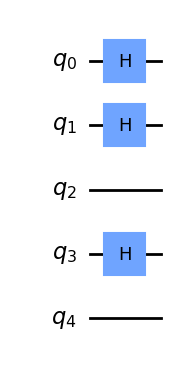

In [4]:
n = 5
circ = QuantumCircuit(n)
search_state = "01010"
positions = list(range(n))
initialzing_positions = [0, 1, 3]
circ.h(initialzing_positions)

circ.draw('mpl')

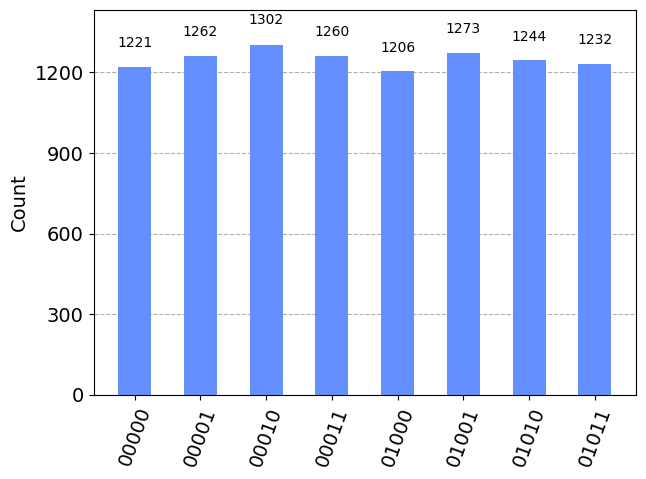

In [5]:
exp_counts = run_simulation(circ.copy(), positions)
plot_histogram(exp_counts)

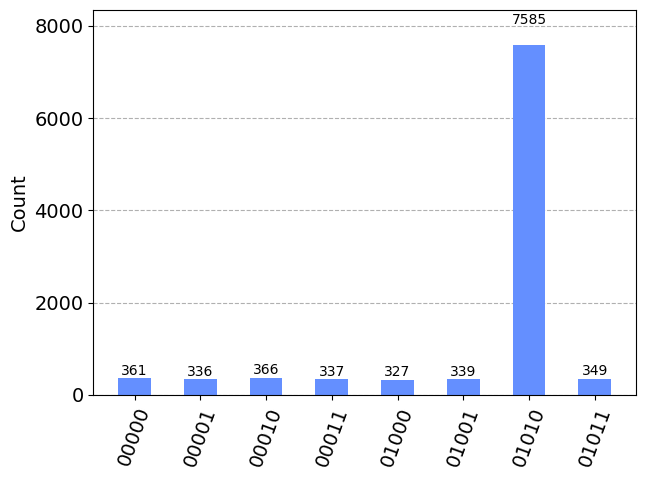

In [6]:
qc = amplitude_amplification(circ, search_state, positions, 'AA')
# qc = amplitude_amplification(circ, search_state, positions, 'sign')
# qc = amplitude_amplification(circ, search_state, positions, 'chebyshev')

exp_counts = run_simulation(qc, positions)
plot_histogram(exp_counts)

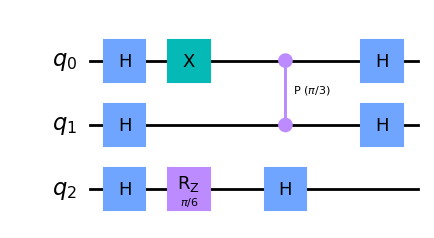

In [7]:
n = 3
positions = [0, 1]
search_state = "11"

circ = QuantumCircuit(n)
circ.h([0, 1, 2])
circ.x(0)
circ.cp(theta=np.pi/3, control_qubit=0, target_qubit=1)
circ.rz(phi=np.pi/6, qubit=2)
circ.h([0, 1, 2])

circ.draw('mpl')

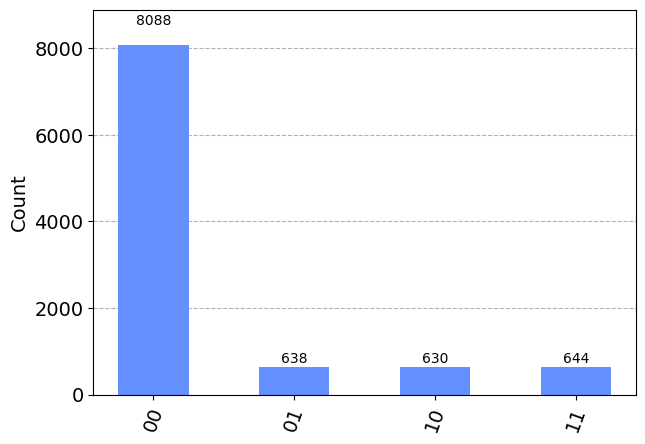

In [8]:
exp_counts = run_simulation(circ.copy(), positions)
plot_histogram(exp_counts)

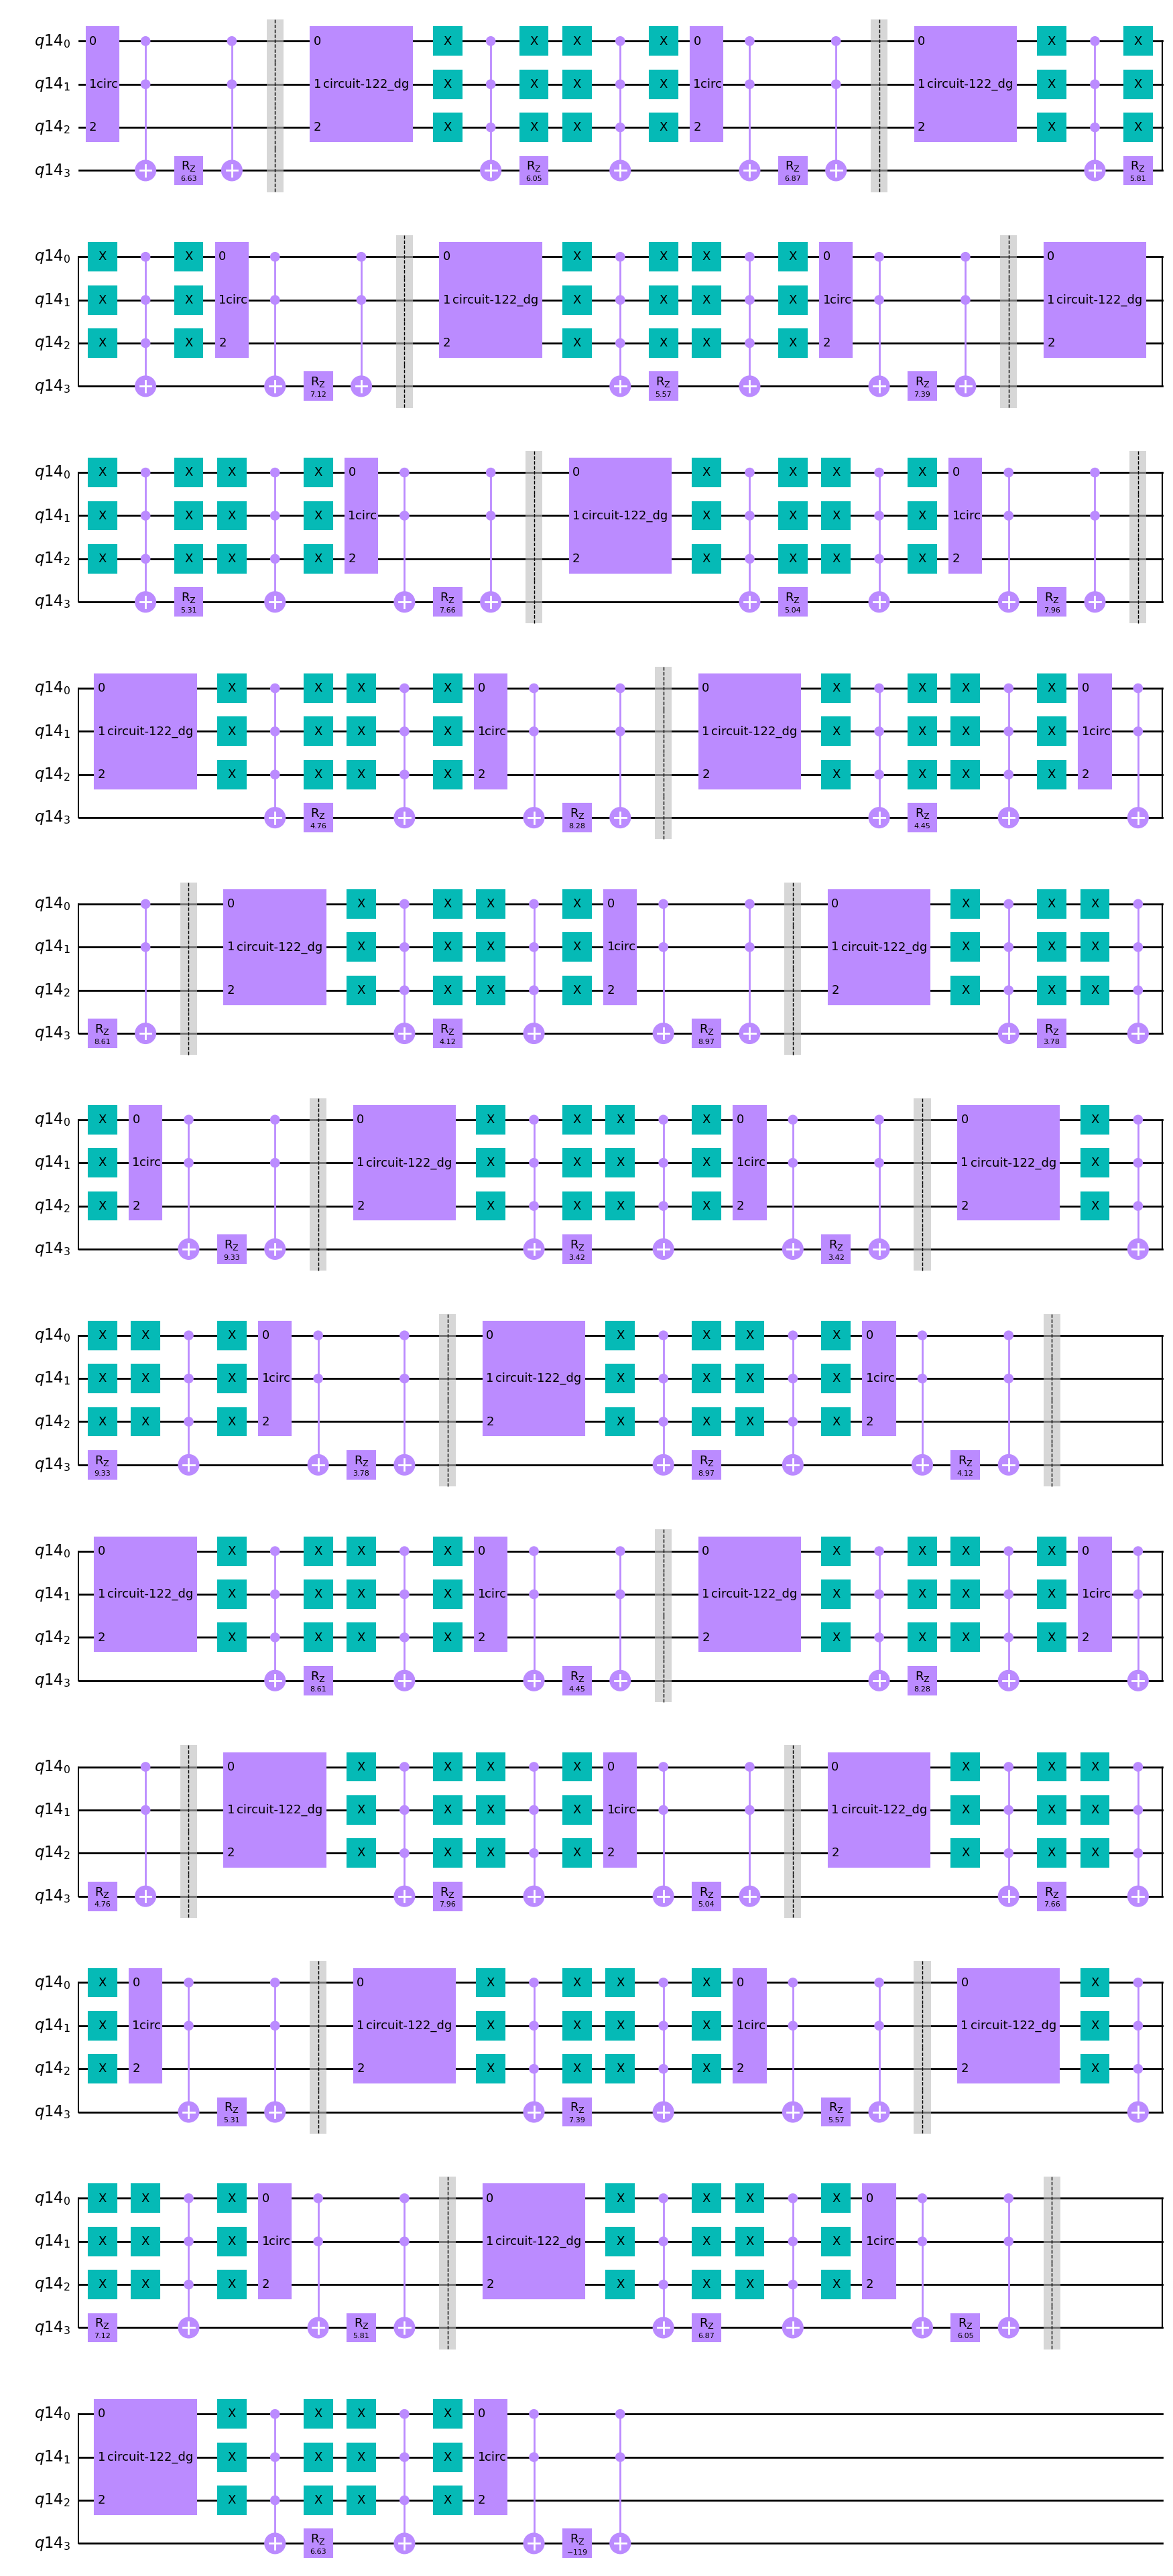

In [9]:
qc = amplitude_amplification(circ, search_state, positions, 'AA')
# qc.draw('mpl')
exp_counts = run_simulation(qc, positions)
plot_histogram(exp_counts)

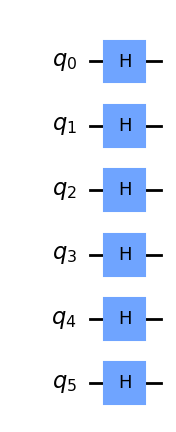

In [10]:
n = 6
circ = QuantumCircuit(n)
search_state = "111111"
positions = list(range(n))
initialzing_positions = list(range(n))
circ.h(initialzing_positions)

circ.draw('mpl')

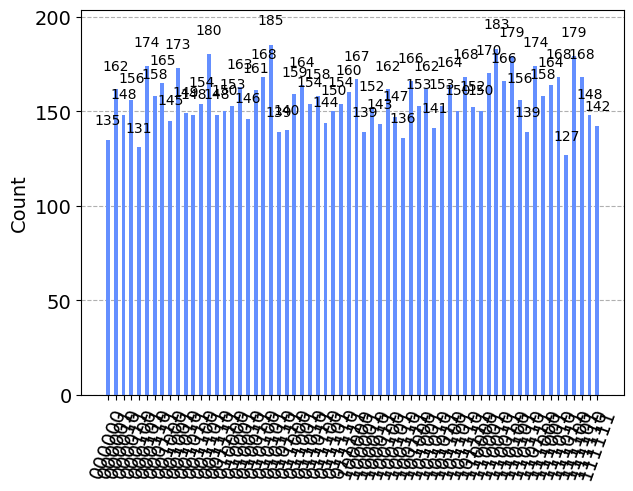

In [11]:
exp_counts = run_simulation(circ.copy(), positions)
plot_histogram(exp_counts)

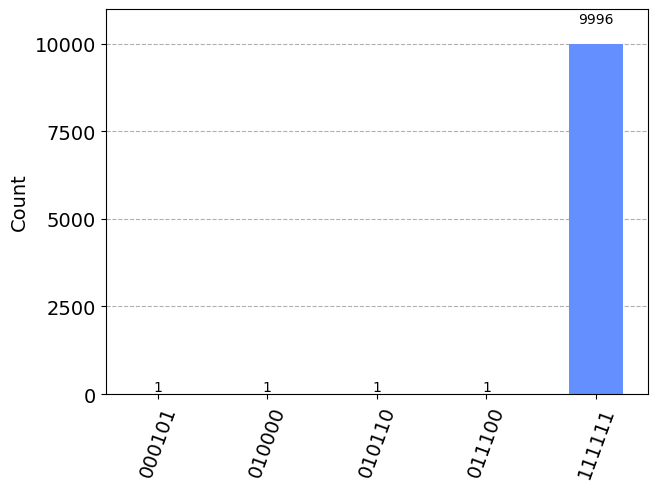

In [12]:
qc = amplitude_amplification(circ, search_state, positions, 'sign')

exp_counts = run_simulation(qc, positions)
plot_histogram(exp_counts)

## Note:
### Even $d$

> $d$ is the **upper bound** of the polynomial degree.

The $d$ for the phase sequence must be **odd**! If it is even,

$$
\text{Poly}^{\text(SV)}(A) := \sum_k \text{Poly}(\sigma_k)|v_k\rangle\langle v_k|,
$$

which means that the output  the input and output spaces are **both the right singular vector space** (which is spanned by $\{H^{\otimes n}|\bold{0}\rangle = |s\rangle\}$!).

In this case, $\text{Poly}(A) = \text{Poly}(\langle t|s\rangle)|s\rangle\langle s|$. Unless we have the ability to transform $|s\rangle$ to $|t\rangle$ (or equivalently, transform $|0\rangle$ to $|t\rangle$), we cannot expect to measure $|t\rangle$ with certain, high probability!

> Probably, the problem of *even $d$* arise from *wrong measurement basis*.

### Block-encoding
The usual notation for block-encoding is

$$
U = \begin{pmatrix}
A & \cdot \\
\cdot & \cdot
\end{pmatrix}.
$$

However, $A$ **need not** be at the top-left corner, in usual matrix representation! (Think about the $A$ and $U$ in our search problem; this is called *projector unitary encoding*.)

### Conventions here
- $R$ (reflection)
  - However, we use `pyqsp` to generate phases in $(W_x, S_z, \langle+|\cdot|+\rangle)$ convention. Thus the phases needs to be converted from $W_x$ to $R$.
  - `phi_seq` is $1$-indexed
  - Does the *measurement basis* matter? ($\langle 0|\cdot|0\rangle, \langle +|\cdot|+\rangle$)

---

## Reference
- [A Grand Unification of Quantum Algorithms](https://arxiv.org/abs/2105.02859)
- [Quantum singular value transformation and beyond: exponential improvements for quantum matrix arithmetics](https://arxiv.org/abs/1806.01838)
- [Quantum Singular Value Transformation (QSVT) in Qiskit (2021 Qiskit Europe Hackathon)](https://github.com/bartubisgin/QSVTinQiskit-2021-Europe-Hackathon-Winning-Project-)
- [Isaac Chuang - Grand unification of quantum algorithms](https://www.youtube.com/watch?v=GFRojXdrVXI&t=1500s)
- [Chebyshev polynomial](https://mathworld.wolfram.com/ChebyshevPolynomialoftheFirstKind.html)